In [2]:
from sklearn import datasets, cross_validation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output 

dataset=pd.read_csv('./input/intial_trainig_stage.csv',index_col='date',parse_dates=['date'])

C:\Users\inha\Anaconda3\envs\tensorflow35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
datalen=len(dataset)
trainlen=int(datalen*0.8)
testlen=datalen-trainlen

In [4]:
training_set=dataset.iloc[0:trainlen,0].values
test_set=dataset.iloc[trainlen:datalen,0].values

In [32]:
#변경 이전
X_train=[]
y_train=[]
for i in range(0,trainlen-1):
    X_train.append(training_set[i])
    y_train.append(training_set[i+1])

In [ ]:
#변경 이후
training_set_pair=[]
for i in range(0,trainlen-1):
    training_set_pair.append([training_set[i],training_set[i+1]])

In [30]:
X_train=np.array(X_train)
X_train

array([367., 397., 388., ..., 392., 370., 365.])

anomaly detection - 일단 training set에서만 anomaly detection 탐지 및 삭제함

In [33]:
import rrcf

# Set tree parameters
num_trees = 40
shingle_size = 10
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()            
    forest.append(tree)
    
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(X_train, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

In [37]:
point_len=len(X_train)
point_len

138239

In [34]:
# For each shingle...
for index, point in enumerate(points): #enumerate(): (인덱스 번호, 컬렉션의 원소) tuple을 반환
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:  # 공분산 계수 계산
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees 

In [39]:
len(avg_codisp)

138230

In [ ]:
cur_dataset_idx=train_len

# 데이터 5개가 들어왔다고 해보자
for i in range(cur_dataset_idx,cur_dataset_idx+5):
    

In [99]:
avg_codisp

{0: 0.0,
 1: 1.0000000000000004,
 2: 1.5000000000000004,
 3: 1.6249999999999996,
 4: 1.75,
 5: 1.7125000000000001,
 6: 2.383333333333333,
 7: 2.2583333333333324,
 8: 3.399999999999999,
 9: 2.058333333333333,
 10: 1.7570833333333333,
 11: 2.4499999999999997,
 12: 2.494999999999999,
 13: 2.4291666666666663,
 14: 2.762500000000001,
 15: 3.3474999999999993,
 16: 3.068988095238095,
 17: 3.4814880952380944,
 18: 5.138630952380953,
 19: 4.2584920634920636,
 20: 3.8481547619047616,
 21: 5.261289682539683,
 22: 5.405208333333334,
 23: 6.456033549783552,
 24: 3.879704184704185,
 25: 4.603055555555557,
 26: 4.883977272727273,
 27: 5.981250000000001,
 28: 5.117321428571428,
 29: 4.816130952380952,
 30: 4.3428544372294375,
 31: 6.074644383394383,
 32: 4.998413461538461,
 33: 2.9877092352092354,
 34: 3.407291666666666,
 35: 4.161309523809524,
 36: 4.760622771836006,
 37: 3.494168258212377,
 38: 4.169688042220937,
 39: 5.638620129870131,
 40: 6.634147910912618,
 41: 3.7167658730158726,
 42: 5.0192390

Z-score: 평균값에서 표준편차의 몇배 정도 떨어져 있다 - 개별 데이터 값에서 평균을 빼고 그 값을 표준편차로 나눈 값

In [107]:
score_mean=np.array(list(avg_codisp.values())).mean()
score_mean

8.078728682265591

In [109]:
score_std=np.array(list(avg_codisp.values())).std()
score_std

7.595964090092897

In [117]:
new_training_set=[]

for i in range(0,len(avg_codisp)):
    t=(avg_codisp[i]-score_mean)/score_std
    if t<=3:
        new_training_set.append(training_set_pair[i])

In [120]:
X_train=[]
y_train=[]
for i in range(0,len(new_training_set)):
    X_train.append(new_training_set[i][0])
    y_train.append(new_training_set[i][1])

In [123]:
# 변경 이전

X_test=[]
y_test=[]
i=0
for i in range(0,testlen-1):
    X_test.append(test_set[i])
    y_test.append(test_set[i+1])

In [124]:
# 주석
#list -> ndim array로 변환
X_train=np.reshape(X_train,(-1,1))
y_train=np.reshape(y_train,(-1,1))
X_test=np.reshape(X_test,(-1,1))
y_test=np.reshape(y_test,(-1,1))

In [125]:
from skgarden import MondrianForestRegressor
mfr=MondrianForestRegressor(random_state=1,n_estimators=100,max_depth=50,bootstrap=True)
mfr.partial_fit(X_train,y_train)
y_pred,y_std=mfr.predict(X_test,return_std=True)

C:\Users\inha\Anaconda3\envs\tensorflow35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\inha\Anaconda3\envs\tensorflow35\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


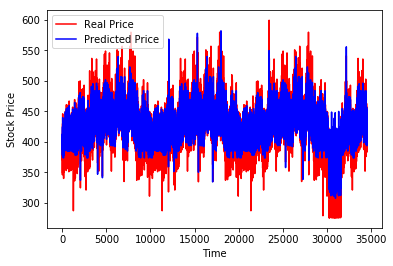

In [126]:
plt.plot(y_test,color='red',label='Real Price')
plt.plot(y_pred,color='blue',label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')

plt.legend()
plt.show()

In [127]:
mfr.score(y_test,y_pred)  # regression을 위한 accuracy_score

0.5464277559916872